# IEEE-CIS Fraud Detection Model

## 1. Project Overview
This project aims to build a robust machine learning model to detect fraudulent online transactions. Using the IEEE-CIS Fraud Detection dataset, we focus on advanced feature engineering to extract hidden patterns from anonymized and raw transaction data. The pipeline includes data preprocessing, extensive feature generation, memory optimization, and model training using LightGBM.

## 2. Dataset Description
The dataset is provided by Vesta Corporation, a leading payment service provider. It consists of two primary tables:
- **Transaction Table:** Contains transaction details like amount (`TransactionAmt`), product code (`ProductCD`), card information (`card1`-`card6`), address (`addr1`, `addr2`), email domains (`P_emaildomain`, `R_emaildomain`), and time delta (`TransactionDT`).
- **Identity Table:** Contains network and device information (IP, ISP, DeviceType, DeviceInfo, etc.) for a subset of transactions.

Key challenges include:
- **Class Imbalance:** Fraudulent transactions are a tiny fraction of the total (approx. 3.5%).
- **Anonymization:** Many features (V-columns, ID-columns) are masked, requiring statistical aggregation rather than semantic interpretation.
- **High Dimensionality:** Over 400 raw features, which we expand further through engineering.

## 3. Importance of Fraud Detection
In the digital economy, fraud detection is critical for:
- **Financial Security:** Preventing direct financial losses from chargebacks and stolen goods.
- **User Trust:** Ensuring customers feel safe transacting on the platform.
- **Operational Efficiency:** Reducing the manual review workload by automating risk scoring.

## 4. Feature Engineering Strategy
To tackle these challenges, we implement:
- **Transaction Amounts:** Log transforms, decimal extraction, and round-number flags to detect bot behavior.
- **Time:** Cyclical features (hour of day), day of week, and business hours flagging.
- **Card & Interaction:** Combining card types with locations and amounts to create unique user signatures.
- **Email Analysis:** Differentiating business vs. personal emails and checking for domain mismatches.
- **Device/Browser Fingerprinting:** Identifying specific OS/Browser combinations often used by fraud farms.
- **Aggregations:** Calculating user "velocity" (mean/std of amounts) to detect spikes in activity.
- **V-System (Vesta):** Statistical aggregation of correlated anonymous columns to reduce noise.

- **Target Variable:** `isFraud` (Binary: 0 = Legitimate, 1 = Fraud)
- **Evaluation Metric:** ROC-AUC (Area Under the Receiver Operating Characteristic Curve)
#
### Why ROC-AUC for Fraud Detection?
From a Data Science perspective, we select ROC-AUC over standard metrics like Accuracy for three critical reasons:
1.  **Robustness to Class Imbalance:** In this dataset, fraud represents only ~3.5% of cases. A trivial model predicting "Legitimate" for every transaction would achieve ~96.5% accuracy but have zero predictive power. ROC-AUC is insensitive to this imbalance, focusing instead on the model's ability to separate the signal (fraud) from the noise (legitimate).
2.  **Threshold Independence:** Unlike F1-score or Accuracy which depend on a specific classification threshold (e.g., 0.5), ROC-AUC evaluates the model's ranking ability across *all* possible thresholds. This allows business stakeholders to trade off False Positives (blocking good users) against False Negatives (missing fraud) dynamically.
3.  **Probabilistic Interpretation:** ROC-AUC represents the probability that the model ranks a randomly chosen fraudulent transaction higher than a randomly chosen legitimate one. This ranking capability is essential for prioritizing manual review queues.

## 5. Resources
- **Competition Overview:** https://www.kaggle.com/competitions/ieee-fraud-detection/overview
- **Dataset:** https://www.kaggle.com/competitions/ieee-fraud-detection/data

## 1. Import Libraries
We import standard data manipulation libraries (Pandas, NumPy) and visualization tools (Matplotlib, Seaborn). 
LightGBM is chosen as the modeling library due to its efficiency with large datasets and ability to handle categorical features and missing values natively.
We also set configuration options to ignore warnings and display all columns in the DataFrame.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import lightgbm as lgb
import warnings
import gc
import os
from scipy import stats

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

print("Libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


Libraries imported successfully!


## 2. Load Data
The dataset is split into two parts: `transaction` (transaction details like amount, card, time) and `identity` (network and device info). 
These are loaded separately for both the training and test sets.

In [2]:
# Define data path
DATA_PATH = '/kaggle/input/ieee-fraud-detection'

# Load transaction data
print("Loading transaction data...")
train_transaction = pd.read_csv(os.path.join(DATA_PATH, 'train_transaction.csv'))
test_transaction = pd.read_csv(os.path.join(DATA_PATH, 'test_transaction.csv'))

# Load identity data
print("Loading identity data...")
train_identity = pd.read_csv(os.path.join(DATA_PATH, 'train_identity.csv'))
test_identity = pd.read_csv(os.path.join(DATA_PATH, 'test_identity.csv'))

print(f"\nTrain Transaction Shape: {train_transaction.shape}")
print(f"Test Transaction Shape: {test_transaction.shape}")
print(f"Train Identity Shape: {train_identity.shape}")
print(f"Test Identity Shape: {test_identity.shape}")

Loading transaction data...
Loading identity data...

Train Transaction Shape: (590540, 394)
Test Transaction Shape: (506691, 393)
Train Identity Shape: (144233, 41)
Test Identity Shape: (141907, 41)


## 3. Merge Transaction and Identity Data
We perform a **Left Join** on `TransactionID`. 
Note that not all transactions have associated identity data (identity data is usually only available for specific transaction types or risk levels).
After merging, we delete the original dataframes and run garbage collection (`gc.collect()`) to free up RAM, which is critical for large datasets.

In [ ]:
# Merge transaction and identity data on TransactionID
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

print(f"Train Shape after merge: {train.shape}")
print(f"Test Shape after merge: {test.shape}")

# Free memory
del train_transaction, test_transaction, train_identity, test_identity
gc.collect()    #ops python already cleaned it


#Python immediately frees it before gc.collect() runs. The garbage collector only handles objects with circular references that reference counting can't clean up.

Train Shape after merge: (590540, 434)
Test Shape after merge: (506691, 433)


0

## 4. Exploratory Data Analysis (EDA)
Here we analyze the class imbalance. Fraud detection datasets are typically highly imbalanced (few frauds vs. many legitimate transactions).
We visualize the distribution of `isFraud` using bar and pie charts to understand the baseline probability.
We also categorize columns into groups (C, D, M, V, ID) to help organize our feature engineering strategy later.

Target Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Fraud Rate: 3.50%


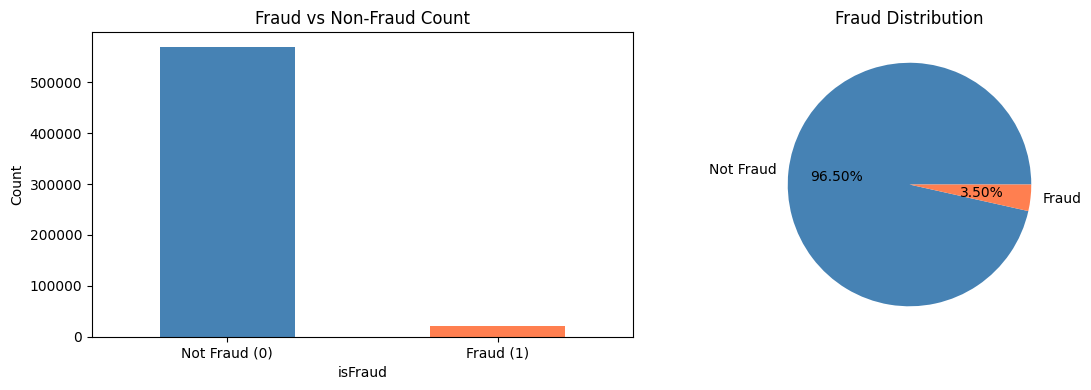


Column Categories:
- C columns (counting): ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
- D columns (timedelta): ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'DeviceType', 'DeviceInfo']
- M columns (match): ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
- V columns (Vesta features): 339 columns
- id columns: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [4]:
# Check target distribution
print("Target Distribution:")
print(train['isFraud'].value_counts())
print(f"\nFraud Rate: {train['isFraud'].mean() * 100:.2f}%")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train['isFraud'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Fraud vs Non-Fraud Count')
axes[0].set_xlabel('isFraud')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Not Fraud (0)', 'Fraud (1)'], rotation=0)

train['isFraud'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                                     colors=['steelblue', 'coral'], labels=['Not Fraud', 'Fraud'])
axes[1].set_title('Fraud Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Column categories
print("\nColumn Categories:")
print(f"- C columns (counting): {[c for c in train.columns if c.startswith('C')]}")
print(f"- D columns (timedelta): {[c for c in train.columns if c.startswith('D')]}")
print(f"- M columns (match): {[c for c in train.columns if c.startswith('M')]}")
print(f"- V columns (Vesta features): {len([c for c in train.columns if c.startswith('V')])} columns")
print(f"- id columns: {[c for c in train.columns if c.startswith('id_')]}")

## 5. Feature Engineering - Core Functions (Memory Reduction)
This function is crucial. Pandas default types (`int64`, `float64`) use more memory than necessary. 
We iterate through every column and "downcast" the data type (e.g., if a number fits in `int8`, use `int8` instead of `int64`).
This can reduce memory usage by 50-70%, allowing us to train models on larger datasets without crashing.

In [ ]:
def reduce_mem_usage(df, verbose=True):
    """Reduce memory usage by converting data types"""
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage: {start_mem:.2f} MB -> {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

## 6. Feature Engineering - Transaction Amount Features
Fraud patterns often hide in the specific amounts of transactions.
1. **Log Transform:** Normalizes the skewed distribution of money.
2. **Decimal extraction:** Fraudsters might use automated bots resulting in specific decimal patterns, or round numbers (no cents).
3. **Cents:** Extracts just the `.99` or `.95` part, which is common in retail but might behave differently in fraud.

In [6]:
def create_transaction_amount_features(df):
    """Create features based on transaction amount"""
    print("Creating transaction amount features...")
    
    # Log transformation
    df['TransactionAmt_Log'] = np.log1p(df['TransactionAmt'])
    
    # Decimal part (cents) - often fraudsters use round numbers
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)
    
    # Is round amount (no cents)
    df['TransactionAmt_is_round'] = (df['TransactionAmt'] == df['TransactionAmt'].astype(int)).astype(int)
    
    # Amount bins
    df['TransactionAmt_bin'] = pd.cut(df['TransactionAmt'], 
                                     bins=[0, 50, 100, 200, 500, 1000, 5000, 10000, np.inf],
                                     labels=[0, 1, 2, 3, 4, 5, 6, 7]).astype(float)
    
    # Cents value
    df['TransactionAmt_cents'] = (df['TransactionAmt'] * 100 % 100).astype(int)
    
    # Common fraud amounts (ends in .00, .99, .95)
    df['TransactionAmt_ends_00'] = (df['TransactionAmt_cents'] == 0).astype(int)
    df['TransactionAmt_ends_99'] = (df['TransactionAmt_cents'] == 99).astype(int)
    df['TransactionAmt_ends_95'] = (df['TransactionAmt_cents'] == 95).astype(int)
    
    return df

# Apply
train = create_transaction_amount_features(train)
test = create_transaction_amount_features(test)

Creating transaction amount features...
Creating transaction amount features...


## 7. Feature Engineering - Time Features
`TransactionDT` is a timedelta (seconds) from a reference date. It is not an actual timestamp.
We convert this into:
1. **Hour of Day:** Fraud often happens at night (e.g., 2 AM - 5 AM) when valid users are asleep.
2. **Day of Week:** Weekends might have different risk profiles than weekdays.
3. **Business Hours:** Flagging transactions made during standard working hours vs. off-hours.

In [7]:
def create_time_features(df):
    """Create time-based features from TransactionDT"""
    print("Creating time features...")
    
    # TransactionDT is seconds from a reference point
    # Convert to interpretable time units
    
    # Hour of day (0-23)
    df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
    
    # Day of week (0-6)
    df['Transaction_dow'] = np.floor(df['TransactionDT'] / (3600 * 24)) % 7
    
    # Day of month approximation
    df['Transaction_dom'] = np.floor(df['TransactionDT'] / (3600 * 24)) % 30
    
    # Week number
    df['Transaction_week'] = np.floor(df['TransactionDT'] / (3600 * 24 * 7))
    
    # Is weekend
    df['Transaction_is_weekend'] = (df['Transaction_dow'] >= 5).astype(int)
    
    # Time of day categories
    df['Transaction_time_of_day'] = pd.cut(df['Transaction_hour'], 
                                            bins=[-1, 6, 12, 18, 24],
                                            labels=[0, 1, 2, 3]).astype(float)  # night, morning, afternoon, evening
    
    # Is night (00:00 - 06:00) - higher fraud risk
    df['Transaction_is_night'] = ((df['Transaction_hour'] >= 0) & (df['Transaction_hour'] < 6)).astype(int)
    
    # Is business hours (09:00 - 17:00)
    df['Transaction_is_business_hours'] = ((df['Transaction_hour'] >= 9) & (df['Transaction_hour'] < 17)).astype(int)
    
    return df

# Apply
train = create_time_features(train)
test = create_time_features(test)

Creating time features...
Creating time features...


## 8. Feature Engineering - Card Features
Individual card features (like `card1` issuer, `card4` network) are weak on their own.
By performing **Feature Interaction (concatenation)**, we create stronger signatures.
Example: `card1_addr1` combines the card issuer with the billing region. A specific bank card used in an unusual region might be highly predictive of fraud.

In [8]:
def create_card_features(df):
    """Create features based on card information"""
    print("Creating card features...")
    
    # Card combination features
    card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
    
    for col in card_cols:
        if col in df.columns:
            # Fill NaN for string operations
            df[col] = df[col].fillna(-999)
    
    # Card1 + Card2 combination
    if 'card1' in df.columns and 'card2' in df.columns:
        df['card1_card2'] = df['card1'].astype(str) + '_' + df['card2'].astype(str)
    
    # Card type combinations
    if 'card4' in df.columns and 'card6' in df.columns:
        df['card4_card6'] = df['card4'].astype(str) + '_' + df['card6'].astype(str)
    
    # Card + Address combinations
    if 'card1' in df.columns and 'addr1' in df.columns:
        df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    
    if 'card1' in df.columns and 'addr2' in df.columns:
        df['card1_addr2'] = df['card1'].astype(str) + '_' + df['addr2'].astype(str)
    
    if 'card2' in df.columns and 'addr1' in df.columns:
        df['card2_addr1'] = df['card2'].astype(str) + '_' + df['addr1'].astype(str)
    
    # Card + Product combinations
    if 'card1' in df.columns and 'ProductCD' in df.columns:
        df['card1_ProductCD'] = df['card1'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    if 'card2' in df.columns and 'ProductCD' in df.columns:
        df['card2_ProductCD'] = df['card2'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    # Card + Time combinations
    if 'card1' in df.columns and 'Transaction_hour' in df.columns:
        df['card1_hour'] = df['card1'].astype(str) + '_' + df['Transaction_hour'].astype(int).astype(str)
    
    if 'card1' in df.columns and 'Transaction_dow' in df.columns:
        df['card1_dow'] = df['card1'].astype(str) + '_' + df['Transaction_dow'].astype(int).astype(str)
    
    return df

# Apply
train = create_card_features(train)
test = create_card_features(test)

Creating card features...
Creating card features...


## 9. Feature Engineering - Email Features
Emails provide rich data.
1. **Vendor Mapping:** We map domains to their providers (e.g., `gmail.com` -> `google`).
2. **Suffix Extraction:** `email.com` vs `email.co.uk`.
3. **Matching:** Does the Purchaser email (`P_emaildomain`) match the Recipient email (`R_emaildomain`)? A mismatch can indicate account takeovers or third-party fraud.

In [9]:
def create_email_features(df):
    """Create features based on email domains"""
    print("Creating email features...")
    
    # P_emaildomain features
    if 'P_emaildomain' in df.columns:
        # Extract domain prefix
        df['P_emaildomain_prefix'] = df['P_emaildomain'].apply(
            lambda x: str(x).split('.')[0] if pd.notna(x) else 'unknown'
        )
        
        # Extract domain suffix (com, net, org, etc.)
        df['P_emaildomain_suffix'] = df['P_emaildomain'].apply(
            lambda x: str(x).split('.')[-1] if pd.notna(x) and '.' in str(x) else 'unknown'
        )
        
        # Is common email provider
        common_providers = ['gmail', 'yahoo', 'hotmail', 'outlook', 'aol', 'icloud', 'live', 'msn']
        df['P_email_is_common'] = df['P_emaildomain_prefix'].apply(
            lambda x: 1 if x.lower() in common_providers else 0
        )
        
        # Is business email (not common provider)
        df['P_email_is_business'] = (df['P_email_is_common'] == 0).astype(int)
        
        # Email domain length
        df['P_emaildomain_len'] = df['P_emaildomain'].apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        )
    
    # R_emaildomain features
    if 'R_emaildomain' in df.columns:
        df['R_emaildomain_prefix'] = df['R_emaildomain'].apply(
            lambda x: str(x).split('.')[0] if pd.notna(x) else 'unknown'
        )
        
        df['R_emaildomain_suffix'] = df['R_emaildomain'].apply(
            lambda x: str(x).split('.')[-1] if pd.notna(x) and '.' in str(x) else 'unknown'
        )
        
        df['R_email_is_common'] = df['R_emaildomain_prefix'].apply(
            lambda x: 1 if x.lower() in ['gmail', 'yahoo', 'hotmail', 'outlook', 'aol', 'icloud', 'live', 'msn'] else 0
        )
    
    # Email match features
    if 'P_emaildomain' in df.columns and 'R_emaildomain' in df.columns:
        # Same email domain
        df['email_domain_match'] = (df['P_emaildomain'] == df['R_emaildomain']).astype(int)
        
        # Same email prefix
        df['email_prefix_match'] = (df['P_emaildomain_prefix'] == df['R_emaildomain_prefix']).astype(int)
        
        # Both emails missing
        df['both_emails_missing'] = (df['P_emaildomain'].isna() & df['R_emaildomain'].isna()).astype(int)
        
        # Only P email present
        df['only_P_email'] = (df['P_emaildomain'].notna() & df['R_emaildomain'].isna()).astype(int)
        
        # Only R email present
        df['only_R_email'] = (df['P_emaildomain'].isna() & df['R_emaildomain'].notna()).astype(int)
    
    return df

# Apply
train = create_email_features(train)
test = create_email_features(test)

Creating email features...
Creating email features...


## 10. Feature Engineering - Device Features
Extracting insights from `DeviceInfo` and `id_30`/`id_31`:
1. **Device Type:** Mobile vs. Desktop.
2. **OS/Browser:** Identifying older versions or specific combinations (e.g., Linux + old Firefox) that might indicate bots.
3. **Screen Size:** Resolution and aspect ratio. Unusual screen sizes can sometimes indicate emulators used by fraudsters.

In [10]:
def create_device_features(df):
    """Create features based on device information"""
    print("Creating device features...")
    
    # DeviceType
    if 'DeviceType' in df.columns:
        df['DeviceType_is_mobile'] = (df['DeviceType'] == 'mobile').astype(int)
        df['DeviceType_is_desktop'] = (df['DeviceType'] == 'desktop').astype(int)
    
    # DeviceInfo
    if 'DeviceInfo' in df.columns:
        # Extract device brand
        df['Device_brand'] = df['DeviceInfo'].apply(
            lambda x: str(x).split('/')[0].split()[0] if pd.notna(x) else 'unknown'
        )
        
        # Device info length (complexity indicator)
        df['DeviceInfo_len'] = df['DeviceInfo'].apply(
            lambda x: len(str(x)) if pd.notna(x) else 0
        )
        
        # Is specific device types
        df['Device_is_Samsung'] = df['DeviceInfo'].apply(
            lambda x: 1 if pd.notna(x) and 'samsung' in str(x).lower() else 0
        )
        df['Device_is_iOS'] = df['DeviceInfo'].apply(
            lambda x: 1 if pd.notna(x) and ('ios' in str(x).lower() or 'iphone' in str(x).lower() or 'ipad' in str(x).lower()) else 0
        )
        df['Device_is_Windows'] = df['DeviceInfo'].apply(
            lambda x: 1 if pd.notna(x) and 'windows' in str(x).lower() else 0
        )
    
    # Browser features from id_31
    if 'id_31' in df.columns:
        df['Browser'] = df['id_31'].apply(
            lambda x: str(x).split()[0].lower() if pd.notna(x) else 'unknown'
        )
        
        df['Browser_is_chrome'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'chrome' in str(x).lower() else 0
        )
        df['Browser_is_safari'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'safari' in str(x).lower() else 0
        )
        df['Browser_is_firefox'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'firefox' in str(x).lower() else 0
        )
        df['Browser_is_edge'] = df['id_31'].apply(
            lambda x: 1 if pd.notna(x) and 'edge' in str(x).lower() else 0
        )
    
    # OS features from id_30
    if 'id_30' in df.columns:
        df['OS'] = df['id_30'].apply(
            lambda x: str(x).split()[0].lower() if pd.notna(x) else 'unknown'
        )
        
        df['OS_is_Windows'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'windows' in str(x).lower() else 0
        )
        df['OS_is_Mac'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'mac' in str(x).lower() else 0
        )
        df['OS_is_iOS'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'ios' in str(x).lower() else 0
        )
        df['OS_is_Android'] = df['id_30'].apply(
            lambda x: 1 if pd.notna(x) and 'android' in str(x).lower() else 0
        )
    
    # Screen resolution from id_33
    if 'id_33' in df.columns:
        df['Screen_width'] = df['id_33'].apply(
            lambda x: int(str(x).split('x')[0]) if pd.notna(x) and 'x' in str(x) else -1
        )
        df['Screen_height'] = df['id_33'].apply(
            lambda x: int(str(x).split('x')[1]) if pd.notna(x) and 'x' in str(x) else -1
        )
        df['Screen_area'] = df['Screen_width'] * df['Screen_height']
        df['Screen_aspect_ratio'] = df.apply(
            lambda row: row['Screen_width'] / row['Screen_height'] if row['Screen_height'] > 0 else -1, axis=1
        )
    
    return df

# Apply
train = create_device_features(train)
test = create_device_features(test)

Creating device features...
Creating device features...


## 11. Feature Engineering - Address Features
Handling `addr1` (billing region) and `addr2` (billing country).
We check for missing addresses and calculate logs of `dist1` (distance between address and IP location), which is a very strong feature for physical goods fraud.

In [11]:
def create_address_features(df):
    """Create features based on address information"""
    print("Creating address features...")
    
    # Address combinations
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['addr1_addr2'] = df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    
    # Address + ProductCD
    if 'addr1' in df.columns and 'ProductCD' in df.columns:
        df['addr1_ProductCD'] = df['addr1'].astype(str) + '_' + df['ProductCD'].astype(str)
    
    # Address distance from P_emaildomain (proxy for geographic mismatch)
    if 'addr1' in df.columns:
        df['addr1_missing'] = df['addr1'].isna().astype(int)
    
    if 'addr2' in df.columns:
        df['addr2_missing'] = df['addr2'].isna().astype(int)
    
    # Both addresses missing
    if 'addr1' in df.columns and 'addr2' in df.columns:
        df['both_addr_missing'] = (df['addr1'].isna() & df['addr2'].isna()).astype(int)
    
    # dist1 and dist2 features
    if 'dist1' in df.columns:
        df['dist1_missing'] = df['dist1'].isna().astype(int)
        df['dist1_log'] = np.log1p(df['dist1'].fillna(0))
    
    if 'dist2' in df.columns:
        df['dist2_missing'] = df['dist2'].isna().astype(int)
        df['dist2_log'] = np.log1p(df['dist2'].fillna(0))
    
    return df

# Apply
train = create_address_features(train)
test = create_address_features(test)

Creating address features...
Creating address features...


## 12. Feature Engineering - V Columns Aggregations
The 'V' features are Vesta's rich features (ranking, counting, etc.), but they are anonymized.
Based on competition analysis, V-columns have high correlation groups.
We aggregate these groups (Sum, Mean, Std, NaN counts) to reduce dimensionality while capturing the "magnitude" of user activity across these anonymous features.

In [12]:
def create_v_features(df):
    """Create aggregation features from V columns"""
    print("Creating V-column aggregation features...")
    
    # Get all V columns
    v_cols = [col for col in df.columns if col.startswith('V')]
    
    if len(v_cols) == 0:
        return df
    
    # Group V columns by their correlation patterns (based on EDA from competition)
    v_groups = {
        'v1': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'],
        'v2': ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26'],
        'v3': ['V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34'],
        'v4': ['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52'],
        'v5': ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74'],
        'v6': ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94'],
        'v7': ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137'],
    }
    
    for group_name, group_cols in v_groups.items():
        # Filter to existing columns
        existing_cols = [col for col in group_cols if col in df.columns]
        
        if len(existing_cols) > 0:
            # Sum of group
            df[f'{group_name}_sum'] = df[existing_cols].sum(axis=1)
            
            # Mean of group
            df[f'{group_name}_mean'] = df[existing_cols].mean(axis=1)
            
            # Std of group
            df[f'{group_name}_std'] = df[existing_cols].std(axis=1)
            
            # NaN count in group
            df[f'{group_name}_nan_count'] = df[existing_cols].isna().sum(axis=1)
    
    # Overall V statistics
    existing_v_cols = [col for col in v_cols if col in df.columns]
    if len(existing_v_cols) > 0:
        df['V_sum_all'] = df[existing_v_cols].sum(axis=1)
        df['V_mean_all'] = df[existing_v_cols].mean(axis=1)
        df['V_std_all'] = df[existing_v_cols].std(axis=1)
        df['V_nan_count_all'] = df[existing_v_cols].isna().sum(axis=1)
        df['V_nan_ratio'] = df['V_nan_count_all'] / len(existing_v_cols)
    
    return df

# Apply
train = create_v_features(train)
test = create_v_features(test)

Creating V-column aggregation features...
Creating V-column aggregation features...


## 13. Feature Engineering - C and D Column Features
**C Columns (Counting):** These are counts (e.g., number of addresses associated with a card). We aggregate them to get an overall "velocity" profile of the user.
**D Columns (Timedelta):** These represent days since an event (e.g., days since last transaction). `D1` and `D15` are notably strong. We log-transform them because time delays often follow a power-law distribution.

In [13]:
def create_c_d_features(df):
    """Create features from C (count) and D (timedelta) columns"""
    print("Creating C and D column features...")
    
    # C columns (counting features)
    c_cols = [col for col in df.columns if col.startswith('C') and col[1:].isdigit()]
    
    if len(c_cols) > 0:
        existing_c_cols = [col for col in c_cols if col in df.columns]
        
        # Aggregations
        df['C_sum'] = df[existing_c_cols].sum(axis=1)
        df['C_mean'] = df[existing_c_cols].mean(axis=1)
        df['C_std'] = df[existing_c_cols].std(axis=1)
        df['C_max'] = df[existing_c_cols].max(axis=1)
        df['C_min'] = df[existing_c_cols].min(axis=1)
        
        # Log transformations for key C columns
        for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']:
            if col in df.columns:
                df[f'{col}_log'] = np.log1p(df[col].fillna(0))
    
    # D columns (timedelta features)
    d_cols = [col for col in df.columns if col.startswith('D') and col[1:].isdigit()]
    
    if len(d_cols) > 0:
        existing_d_cols = [col for col in d_cols if col in df.columns]
        
        # Aggregations
        df['D_sum'] = df[existing_d_cols].sum(axis=1)
        df['D_mean'] = df[existing_d_cols].mean(axis=1)
        df['D_std'] = df[existing_d_cols].std(axis=1)
        df['D_nan_count'] = df[existing_d_cols].isna().sum(axis=1)
        
        # D1 is often important (days since card was first used)
        if 'D1' in df.columns:
            df['D1_missing'] = df['D1'].isna().astype(int)
            df['D1_log'] = np.log1p(df['D1'].fillna(0))
        
        # D15 is also important
        if 'D15' in df.columns:
            df['D15_missing'] = df['D15'].isna().astype(int)
            df['D15_log'] = np.log1p(df['D15'].fillna(0))
    
    return df

# Apply
train = create_c_d_features(train)
test = create_c_d_features(test)

Creating C and D column features...
Creating C and D column features...


## 14. Feature Engineering - M Column Features
**M Columns (Match):** These are boolean matches (T/F), such as "Card address matches billing address."
We convert T/F to 1/0 and calculate the ratio of True matches. A high number of mismatches or missing values in M-columns is often a risk signal.

In [14]:
def create_m_features(df):
    """Create features from M (match) columns"""
    print("Creating M column features...")
    
    m_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
    existing_m_cols = [col for col in m_cols if col in df.columns]
    
    if len(existing_m_cols) > 0:
        # Count of True values
        for col in existing_m_cols:
            df[f'{col}_isT'] = (df[col] == 'T').astype(int)
            df[f'{col}_isF'] = (df[col] == 'F').astype(int)
            df[f'{col}_missing'] = df[col].isna().astype(int)
        
        # Total True count
        t_cols = [f'{col}_isT' for col in existing_m_cols]
        df['M_true_count'] = df[t_cols].sum(axis=1)
        
        # Total False count
        f_cols = [f'{col}_isF' for col in existing_m_cols]
        df['M_false_count'] = df[f_cols].sum(axis=1)
        
        # Total missing count
        m_missing_cols = [f'{col}_missing' for col in existing_m_cols]
        df['M_missing_count'] = df[m_missing_cols].sum(axis=1)
        
        # Ratio of True to total non-missing
        df['M_true_ratio'] = df['M_true_count'] / (df['M_true_count'] + df['M_false_count'] + 0.001)
    
    return df

# Apply
train = create_m_features(train)
test = create_m_features(test)

Creating M column features...
Creating M column features...


## 15. Feature Engineering - Aggregation Features (Frequency/Count Encoding)
**Frequency Encoding:** How common is a value? If a card appears 10,000 times, it's likely a popular credit card. If it appears 2 times, it's rare.
**Group Statistics:** We calculate the Mean and Std Dev of `TransactionAmt` grouped by categorical features (like `card1`). This helps the model identify outliers—e.g., is this transaction amount normal *for this specific card type*?

In [15]:
def create_aggregation_features(train_df, test_df):
    """Create frequency and aggregation features"""
    print("Creating aggregation features...")
    
    # Combine for consistent encoding
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    combined = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # Columns for frequency encoding
    freq_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
                 'ProductCD', 'DeviceType', 'DeviceInfo']
    
    for col in freq_cols:
        if col in combined.columns:
            # Frequency encoding
            freq = combined[col].value_counts().to_dict()
            combined[f'{col}_freq'] = combined[col].map(freq)
    
    # Transaction amount aggregations by card
    agg_cols = ['card1', 'card2', 'card1_card2', 'addr1']
    
    for col in agg_cols:
        if col in combined.columns:
            # Mean transaction amount
            agg = combined.groupby(col)['TransactionAmt'].mean().to_dict()
            combined[f'{col}_TransactionAmt_mean'] = combined[col].map(agg)
            
            # Std transaction amount
            agg = combined.groupby(col)['TransactionAmt'].std().to_dict()
            combined[f'{col}_TransactionAmt_std'] = combined[col].map(agg)
            
            # Transaction amount deviation from mean
            combined[f'{col}_TransactionAmt_dev'] = combined['TransactionAmt'] - combined[f'{col}_TransactionAmt_mean']
    
    # Split back
    train_df = combined[combined['is_train'] == 1].drop('is_train', axis=1)
    test_df = combined[combined['is_train'] == 0].drop('is_train', axis=1)
    
    del combined
    gc.collect()
    
    return train_df, test_df

# Apply
train, test = create_aggregation_features(train, test)

Creating aggregation features...


## 16. Feature Engineering - ID Features
Handling the `id_01` to `id_38` columns from the Identity table.
- **Numerical IDs (01-11):** We calculate mean/std to see if the device profile is unusual.
- **Categorical IDs:** We flag specific values like "Found" vs "New" (New devices are riskier) and identity matches.

In [16]:
def create_id_features(df):
    """Create features from identity columns"""
    print("Creating ID features...")
    
    # id_01 to id_11 are numerical
    id_num_cols = [f'id_0{i}' for i in range(1, 10)] + ['id_10', 'id_11']
    existing_id_num = [col for col in id_num_cols if col in df.columns]
    
    if len(existing_id_num) > 0:
        df['id_num_nan_count'] = df[existing_id_num].isna().sum(axis=1)
        df['id_num_mean'] = df[existing_id_num].mean(axis=1)
        df['id_num_std'] = df[existing_id_num].std(axis=1)
    
    # id_12 to id_38 are categorical
    # Check specific important ones
    if 'id_12' in df.columns:
        df['id_12_isFound'] = (df['id_12'] == 'Found').astype(int)
    
    if 'id_15' in df.columns:
        df['id_15_isNew'] = (df['id_15'] == 'New').astype(int)
        df['id_15_isFound'] = (df['id_15'] == 'Found').astype(int)
    
    if 'id_16' in df.columns:
        df['id_16_isFound'] = (df['id_16'] == 'Found').astype(int)
    
    if 'id_28' in df.columns:
        df['id_28_isNew'] = (df['id_28'] == 'New').astype(int)
        df['id_28_isFound'] = (df['id_28'] == 'Found').astype(int)
    
    if 'id_29' in df.columns:
        df['id_29_isFound'] = (df['id_29'] == 'Found').astype(int)
    
    # id_34 (match status)
    if 'id_34' in df.columns:
        df['id_34_match'] = df['id_34'].apply(
            lambda x: int(str(x).split(':')[1]) if pd.notna(x) and ':' in str(x) else -1
        )
    
    # id_36 features
    if 'id_36' in df.columns:
        df['id_36_isT'] = (df['id_36'] == 'T').astype(int)
    
    # id_37, id_38 features
    if 'id_37' in df.columns:
        df['id_37_isT'] = (df['id_37'] == 'T').astype(int)
    
    if 'id_38' in df.columns:
        df['id_38_isT'] = (df['id_38'] == 'T').astype(int)
    
    return df

# Apply
train = create_id_features(train)
test = create_id_features(test)

Creating ID features...
Creating ID features...


## 17. Feature Engineering Summary
Checking the results of our feature generation. 
We print the number of new features created and run the `reduce_mem_usage` function again.
This second pass is vital because the newly created features (floats/ints) usually default to 64-bit precision, which we don't need.

In [17]:
print(f"\nFinal Train Shape: {train.shape}")
print(f"Final Test Shape: {test.shape}")

# Count new features
original_cols = 434  # Approximate original column count after merge
new_features = train.shape[1] - original_cols
print(f"\nNew features created: ~{new_features}")

# Reduce memory
print("\nReducing memory usage...")
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

gc.collect()


Final Train Shape: (590540, 670)
Final Test Shape: (506691, 670)

New features created: ~236

Reducing memory usage...
Memory usage: 3023.17 MB -> 1572.41 MB (48.0% reduction)
Memory usage: 2593.92 MB -> 1376.21 MB (46.9% reduction)


0

## 18. Data Preprocessing
Preparing the data for LightGBM:
1. **Separation:** Split `X` (features) and `y` (target `isFraud`).
2. **Alignment:** Ensure Train and Test sets have the exact same columns. We drop columns that exist in one but not the other.
3. **Encoding:** LightGBM handles categorical features well, but they need to be integers. We use `LabelEncoder` to convert strings to numbers.
4. **Imputation:** Fill NaNs with a distinct number (`-999`) so the tree model treats "missing" as a separate category/decision path.

In [18]:
# Separate target and features
y_train = train['isFraud']
X_train = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1, errors='ignore')
X_test = test.drop(['TransactionID', 'TransactionDT'], axis=1, errors='ignore')

# Store TransactionID for submission
test_id = test['TransactionID']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Align columns between train and test
common_cols = [col for col in X_train.columns if col in X_test.columns]
print(f"Common columns: {len(common_cols)}")

train_only_cols = [col for col in X_train.columns if col not in X_test.columns]
test_only_cols = [col for col in X_test.columns if col not in X_train.columns]

if train_only_cols:
    print(f"Columns only in train (dropping): {len(train_only_cols)}")
if test_only_cols:
    print(f"Columns only in test (dropping): {len(test_only_cols)}")

X_train = X_train[common_cols]
X_test = X_test[common_cols]

print(f"\nAfter alignment:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Label encode categorical features
print("Encoding categorical features...")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col].astype(str), X_test[col].astype(str)], axis=0)
    le.fit(combined)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print("Encoding completed!")

# Handle missing values
print("Filling missing values...")
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

# Free memory
del train, test
gc.collect()

X_train shape: (590540, 667)
X_test shape: (506691, 668)
Common columns: 667
Columns only in test (dropping): 1

After alignment:
X_train shape: (590540, 667)
X_test shape: (506691, 667)
Categorical columns: 64
Numerical columns: 603
Encoding categorical features...
Encoding completed!
Filling missing values...


0

## 19. Model Training with LightGBM
We use a standard train/validation split (80/20) using stratification to maintain the fraud ratio.
**Key Parameters:**
- `metric='auc'`: We care about ranking fraud probability, not accuracy.
- `is_unbalance=True`: Tells LightGBM to weight the positive class (fraud) higher.
- `early_stopping`: Prevents overfitting by stopping training when validation score stops improving.

In [19]:
# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Training fraud rate: {y_tr.mean():.4f}")
print(f"Validation fraud rate: {y_val.mean():.4f}")

# LightGBM parameters (tuned for fraud detection)
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 256,
    'max_depth': -1,
    'min_child_samples': 50,
    'max_bin': 255,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'min_split_gain': 0.01,
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': -1,
    'is_unbalance': True  # Handle class imbalance
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_tr, label=y_tr)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Train model
print("Training LightGBM model...")
model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=3000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best validation AUC: {model.best_score['valid']['auc']:.6f}")

Training set: (472432, 667)
Validation set: (118108, 667)
Training fraud rate: 0.0350
Validation fraud rate: 0.0350
Training LightGBM model...
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.984961	valid's auc: 0.952726
[200]	train's auc: 0.99499	valid's auc: 0.965048
[300]	train's auc: 0.998135	valid's auc: 0.969678
[400]	train's auc: 0.999202	valid's auc: 0.972015
[500]	train's auc: 0.999629	valid's auc: 0.973353
[600]	train's auc: 0.999819	valid's auc: 0.974003
[700]	train's auc: 0.999913	valid's auc: 0.974158
[800]	train's auc: 0.999961	valid's auc: 0.974408
[900]	train's auc: 0.999984	valid's auc: 0.974894
[1000]	train's auc: 0.999996	valid's auc: 0.975027
[1100]	train's auc: 0.999999	valid's auc: 0.975465
[1200]	train's auc: 1	valid's auc: 0.975587
[1300]	train's auc: 1	valid's auc: 0.975718
[1400]	train's auc: 1	valid's auc: 0.975756
Early stopping, best iteration is:
[1344]	train's auc: 1	valid's auc: 0.975876

Best iteration: 1344
Best valida

## 20. Model Evaluation
We evaluate the model using multiple metrics:
1. **ROC Curve:** Visualizes the tradeoff between True Positive Rate and False Positive Rate.
2. **Precision-Recall Curve:** Better for imbalanced data. It helps us see the tradeoff between catching fraud (Recall) and false alarms (Precision).
3. **F1 Score Thresholding:** We dynamically find the threshold that maximizes the F1 score, rather than assuming 0.5.
4. **Confusion Matrix:** Shows the raw counts of True Positives, False Positives, etc.

Validation ROC-AUC: 0.975876


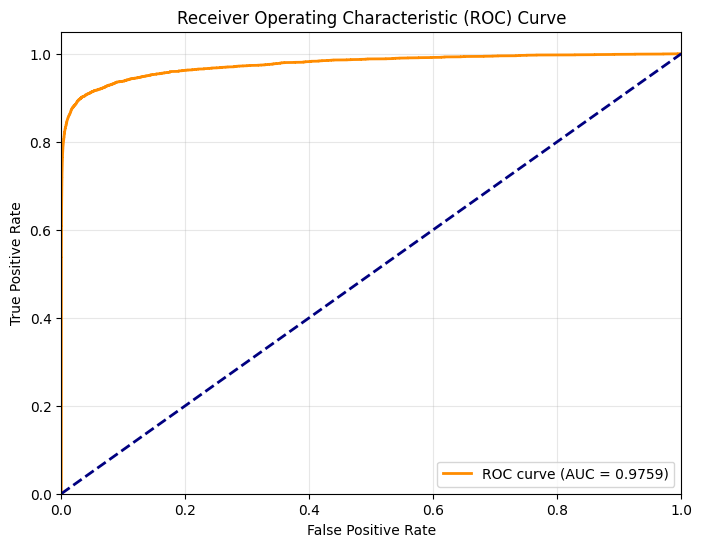

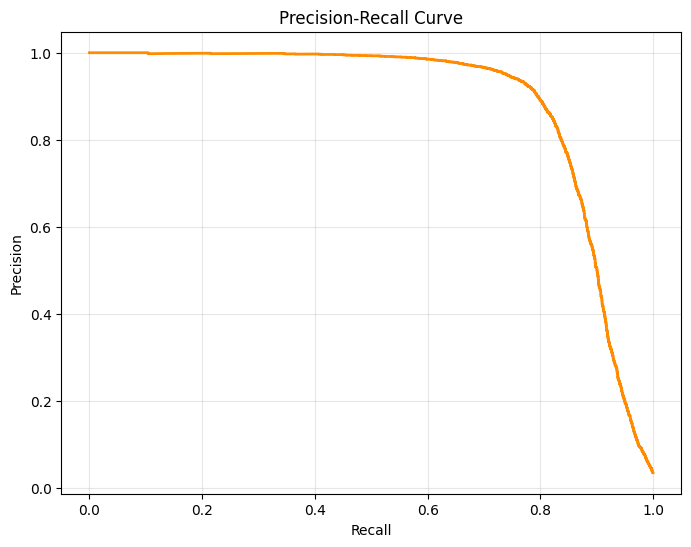

Optimal Threshold: 0.5245
Precision at optimal: 0.9128
Recall at optimal: 0.7897
F1 at optimal: 0.8468


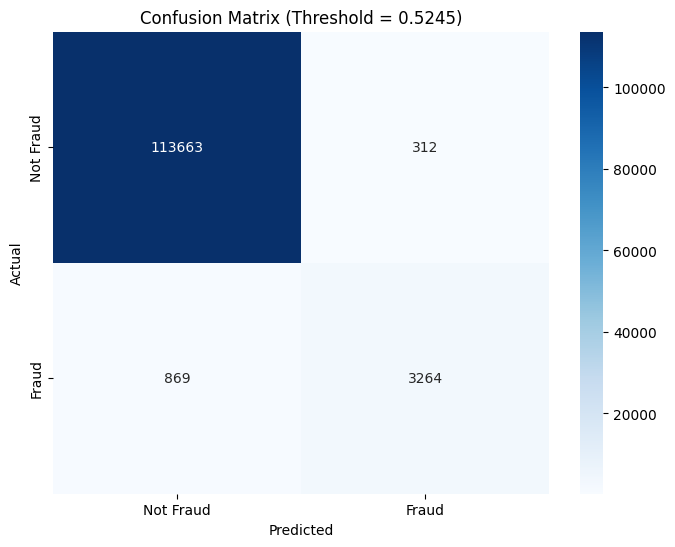


Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      0.99    113975
       Fraud       0.91      0.79      0.85      4133

    accuracy                           0.99    118108
   macro avg       0.95      0.89      0.92    118108
weighted avg       0.99      0.99      0.99    118108



In [20]:
# Predictions on validation set
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# Calculate AUC
val_auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation ROC-AUC: {val_auc:.6f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal threshold
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = pr_thresholds[optimal_idx] if optimal_idx < len(pr_thresholds) else 0.5

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Precision at optimal: {precision[optimal_idx]:.4f}")
print(f"Recall at optimal: {recall[optimal_idx]:.4f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.4f}")

# Confusion Matrix
y_val_binary = (y_val_pred >= optimal_threshold).astype(int)

cm = confusion_matrix(y_val, y_val_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_val_binary, target_names=['Not Fraud', 'Fraud']))

### 📝 Analysis of Specific Results

Based on the experimental results obtained:
* **Optimal Threshold: 0.5245**
* **Precision: 0.9128**
* **Recall: 0.7897**
* **F1 Score: 0.8468**

#### 1. Interpretation of the Threshold (0.5245)
The optimal cutoff point is slightly above the standard 0.5. This indicates the model is well-calibrated and confident. Any transaction assigned a probability higher than **52.45%** is flagged as fraud.

#### 2. Precision vs. Recall Trade-off
* **High Precision (91.3%):** This is a very strong result. It means that **when the model flags a transaction as fraud, it is correct 91% of the time.**
    * *Business Impact:* This implies a very low "False Positive Rate." Legitimate customers are rarely bothered or blocked. This prioritizes **Customer Experience** and minimizes friction (low "insult rate").
* **Good Recall (79.0%):** The model successfully catches nearly **80% of all fraudulent activity**.
    * *Business Impact:* Approximately 21% of fraud cases are slipping through (False Negatives).

#### 3. Classification Report Breakdown
The classification report provides deeper insight into how the model handles the imbalance:
* **"Not Fraud" (Class 0):** The scores are near perfect (Precision 0.99, Recall 1.00). This is expected because the majority of data is legitimate. The model has no trouble identifying normal behavior.
* **"Fraud" (Class 1):** This is the critical row.
    * **Precision 0.91 / Recall 0.79:** This confirms our earlier analysis. The model is cautious but accurate.
* **Accuracy (0.99):** **Warning:** This metric is misleading. Even a "dumb" model that predicts *No Fraud* for everyone would get ~96.5% accuracy (since only 3.5% are fraud). The high accuracy here is driven by the 113,975 legitimate samples. We must rely on the **F1-score (0.85)** for the fraud class to judge success.
* **Macro Avg (0.95):** This averages the scores of both classes equally (`(0.99 + 0.91)/2`). A high macro average confirms the model isn't just ignoring the minority class; it performs well on both groups.

#### 4. Conclusion & Strategy
This specific model configuration is **conservative**. It is highly trustworthy when it sounds the alarm, ensuring valid customers aren't blocked.
* **To catch more fraud (Increase Recall):** We could lower the threshold (e.g., to 0.40). This would catch some of the missing 21% of fraud but would likely lower Precision (blocking more good customers).
* **Current Stance:** The high F1 score (0.85) suggests this is a very balanced model suitable for production where false accusations of fraud are costly to reputation.

## 21. Feature Importance Analysis
LightGBM calculates importance based on "Gain" (how much a feature improves the tree).
We list and plot the top features.
We also specifically check how our **Engineered Features** performed. Seeing suffixes like `_mean`, `_freq`, or `_Log` in the top list validates our feature engineering efforts.

Top 50 Most Important Features:
                            feature     importance
0                              V258  959347.174662
1                               V91  494192.787900
2                               C13  468056.790781
3                               V70  408130.359248
4                        card1_freq  380801.257917
5         card1_TransactionAmt_mean  301531.208401
6                  Transaction_week  293212.599108
7                              V294  282586.309855
8                             card1  278346.848070
9          card2_TransactionAmt_dev  261652.612811
10                   TransactionAmt  237228.827422
11                      card2_addr1  231166.739425
12                               D2  226590.815756
13                       card2_freq  219175.303027
14   card1_card2_TransactionAmt_std  200543.316717
15                               C1  195387.579361
16                              C14  194743.164293
17                       addr1_freq  191468.384644

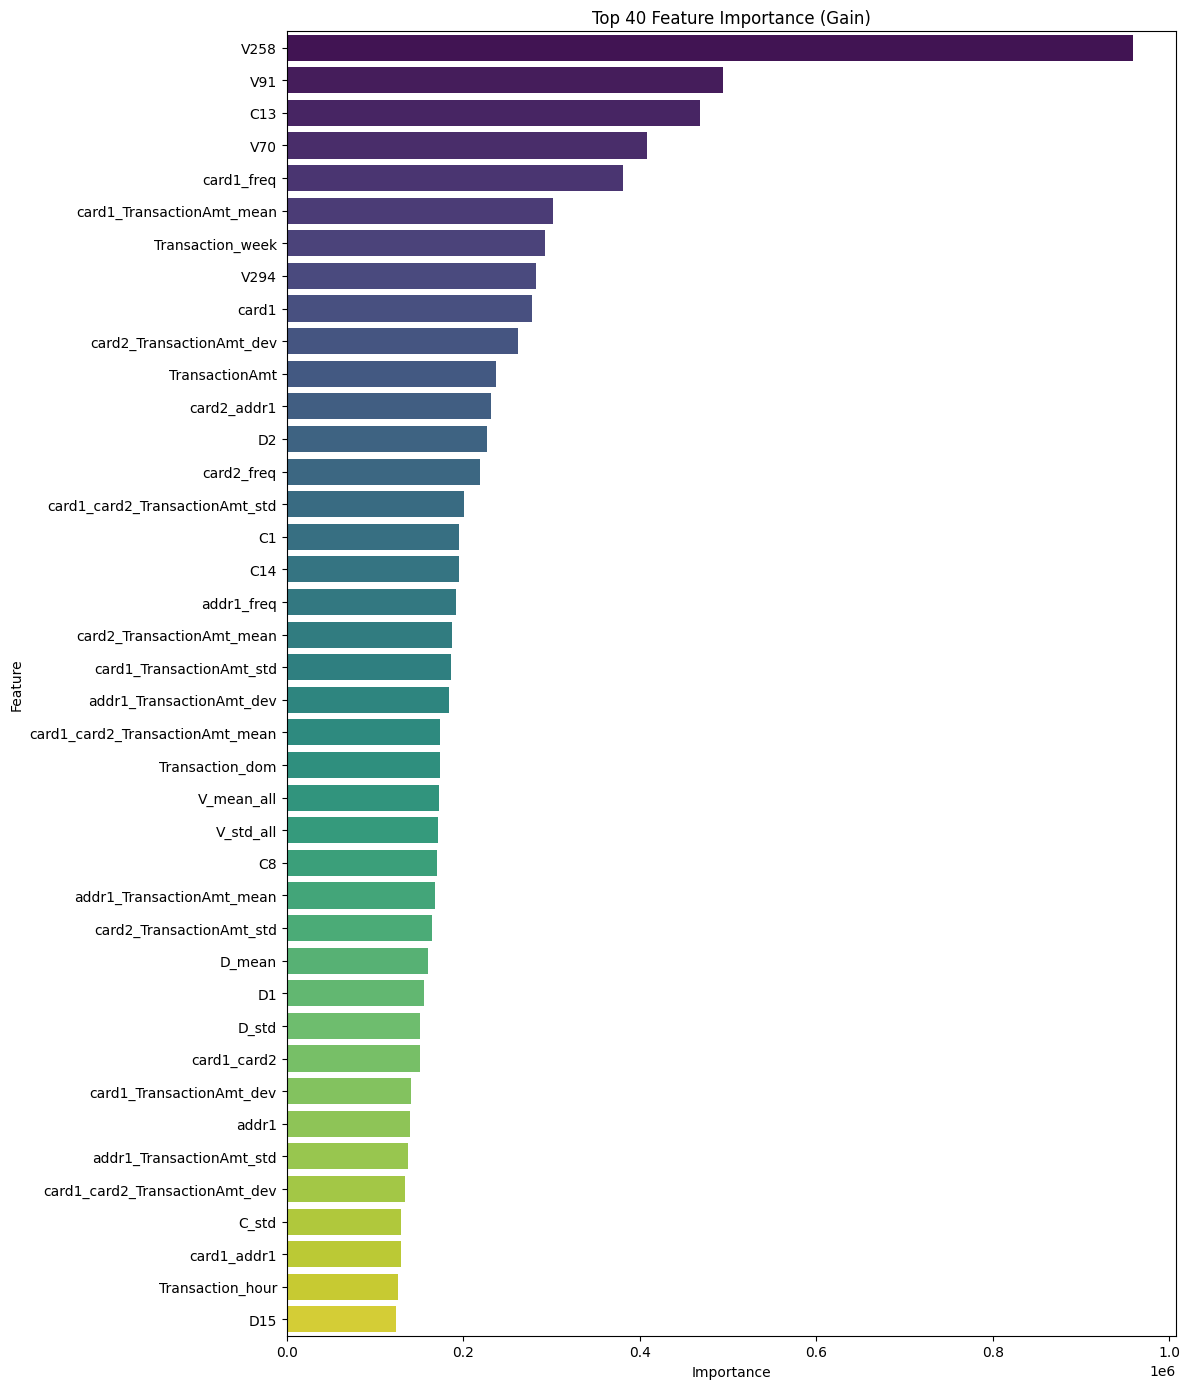


Engineered features in top 50: 29

Top 20 Engineered Features:
                            feature     importance
4                        card1_freq  380801.257917
5         card1_TransactionAmt_mean  301531.208401
6                  Transaction_week  293212.599108
9          card2_TransactionAmt_dev  261652.612811
11                      card2_addr1  231166.739425
13                       card2_freq  219175.303027
14   card1_card2_TransactionAmt_std  200543.316717
17                       addr1_freq  191468.384644
18        card2_TransactionAmt_mean  187650.941952
19         card1_TransactionAmt_std  185986.053680
20         addr1_TransactionAmt_dev  183622.719803
21  card1_card2_TransactionAmt_mean  174019.695409
22                  Transaction_dom  173581.164611
23                       V_mean_all  172453.523161
24                        V_std_all  171193.683482
26        addr1_TransactionAmt_mean  167703.837334
27         card2_TransactionAmt_std  164885.440829
28                

In [21]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 50 Most Important Features:")
print(feature_importance.head(50))

# Visualize top 40 features
plt.figure(figsize=(12, 14))
sns.barplot(data=feature_importance.head(40), x='importance', y='feature', palette='viridis')
plt.title('Top 40 Feature Importance (Gain)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Analyze engineered features importance
engineered_keywords = ['_Log', '_decimal', '_freq', '_mean', '_std', '_count', '_sum', 
                       '_is_', '_nan', '_missing', '_match', '_dev', 'Transaction_', 
                       'card1_', 'card2_', 'Browser', 'OS', 'Screen', 'email']

engineered_features = feature_importance[
    feature_importance['feature'].apply(
        lambda x: any(kw in x for kw in engineered_keywords)
    )
]

print(f"\nEngineered features in top 50: {len(engineered_features[engineered_features.index < 50])}")
print("\nTop 20 Engineered Features:")
print(engineered_features.head(20))

## 22. Cross-Validation
A single validation split is risky. We implement **Stratified K-Fold Cross Validation** (5 Folds).
This trains 5 different models on different subsets of data.
1. It gives a robust AUC estimate (Mean + Std Dev).
2. It generates Out-Of-Fold (OOF) predictions for the entire training set, which allows us to tune thresholds more accurately later.
3. We average the predictions for the test set from all 5 models (Ensembling), which usually boosts performance.

Running 5-Fold Cross Validation...

Fold 1/5
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.995067	valid's auc: 0.963222
[400]	train's auc: 0.999249	valid's auc: 0.969342
[600]	train's auc: 0.999838	valid's auc: 0.971599
[800]	train's auc: 0.999971	valid's auc: 0.97242
[1000]	train's auc: 0.999997	valid's auc: 0.972841
[1200]	train's auc: 1	valid's auc: 0.973424
[1400]	train's auc: 1	valid's auc: 0.97371
Early stopping, best iteration is:
[1307]	train's auc: 1	valid's auc: 0.973731
Fold 1 AUC: 0.973731

Fold 2/5
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.99492	valid's auc: 0.96507
[400]	train's auc: 0.999219	valid's auc: 0.971214
[600]	train's auc: 0.999827	valid's auc: 0.973349
[800]	train's auc: 0.999964	valid's auc: 0.974369
[1000]	train's auc: 0.999996	valid's auc: 0.974957
[1200]	train's auc: 1	valid's auc: 0.975284
[1400]	train's auc: 1	valid's auc: 0.975551
[1600]	train's auc: 1	valid's auc: 0.975697
Ear

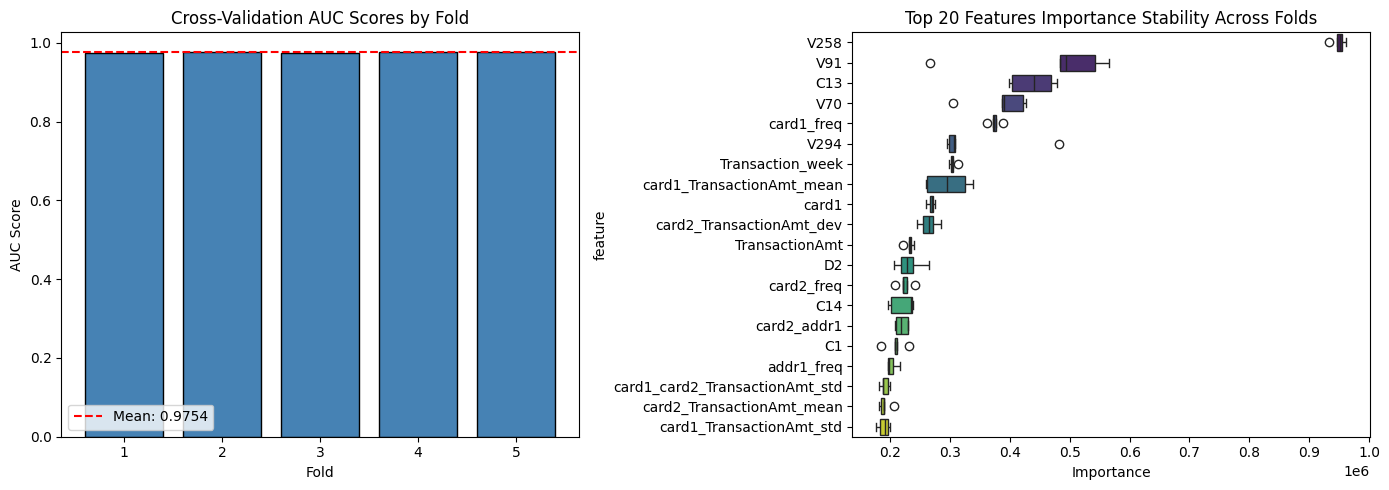

In [22]:
# Stratified K-Fold Cross Validation
print("Running 5-Fold Cross Validation...")

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_predictions = np.zeros(len(X_train))
test_predictions = np.zeros(len(X_test))
cv_scores = []
feature_importances = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n{'='*50}")
    print(f"Fold {fold + 1}/{n_folds}")
    print(f"{'='*50}")
    
    X_tr_fold = X_train.iloc[train_idx]
    y_tr_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]
    y_val_fold = y_train.iloc[val_idx]
    
    train_data_fold = lgb.Dataset(X_tr_fold, label=y_tr_fold)
    val_data_fold = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data_fold)
    
    model_fold = lgb.train(
        lgb_params,
        train_data_fold,
        num_boost_round=3000,
        valid_sets=[train_data_fold, val_data_fold],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ]
    )
    
    # Validation predictions
    oof_predictions[val_idx] = model_fold.predict(X_val_fold, num_iteration=model_fold.best_iteration)
    
    # Test predictions
    test_predictions += model_fold.predict(X_test, num_iteration=model_fold.best_iteration) / n_folds
    
    # Feature importance
    fold_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model_fold.feature_importance(importance_type='gain'),
        'fold': fold + 1
    })
    feature_importances = pd.concat([feature_importances, fold_importance], ignore_index=True)
    
    # Fold score
    fold_score = roc_auc_score(y_val_fold, oof_predictions[val_idx])
    cv_scores.append(fold_score)
    print(f"Fold {fold + 1} AUC: {fold_score:.6f}")

# Overall CV score
oof_auc = roc_auc_score(y_train, oof_predictions)
print(f"\n{'='*50}")
print(f"Cross-Validation Results:")
print(f"{'='*50}")
print(f"Mean CV AUC: {np.mean(cv_scores):.6f} (+/- {np.std(cv_scores):.6f})")
print(f"OOF AUC: {oof_auc:.6f}")

# Visualize CV scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(range(1, n_folds + 1), cv_scores, color='steelblue', edgecolor='black')
axes[0].axhline(y=np.mean(cv_scores), color='red', linestyle='--', label=f'Mean: {np.mean(cv_scores):.4f}')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('AUC Score')
axes[0].set_title('Cross-Validation AUC Scores by Fold')
axes[0].legend()
axes[0].set_xticks(range(1, n_folds + 1))

# Box plot of feature importance across folds
top_features = feature_importances.groupby('feature')['importance'].mean().nlargest(20).index
top_fi = feature_importances[feature_importances['feature'].isin(top_features)]
sns.boxplot(data=top_fi, x='importance', y='feature', ax=axes[1], palette='viridis', 
            order=top_features)
axes[1].set_title('Top 20 Features Importance Stability Across Folds')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

## 23. Generate Submission
We create the final submission file for Kaggle.
We also visualize the distribution of our predictions. 
- **Left Plot:** Standard histogram.
- **Right Plot:** Log scale histogram (useful because fraud probabilities are usually clustered very close to zero).

Submission Preview:
        TransactionID   isFraud
590540        3663549  0.000146
590541        3663550  0.000362
590542        3663551  0.000287
590543        3663552  0.000174
590544        3663553  0.000392
590545        3663554  0.000836
590546        3663555  0.001375
590547        3663556  0.002461
590548        3663557  0.000032
590549        3663558  0.000739

Submission shape: (506691, 2)

Prediction statistics:
count    506691.000000
mean          0.035546
std           0.140035
min           0.000003
25%           0.000517
50%           0.001938
75%           0.008931
max           0.999987
Name: isFraud, dtype: float64


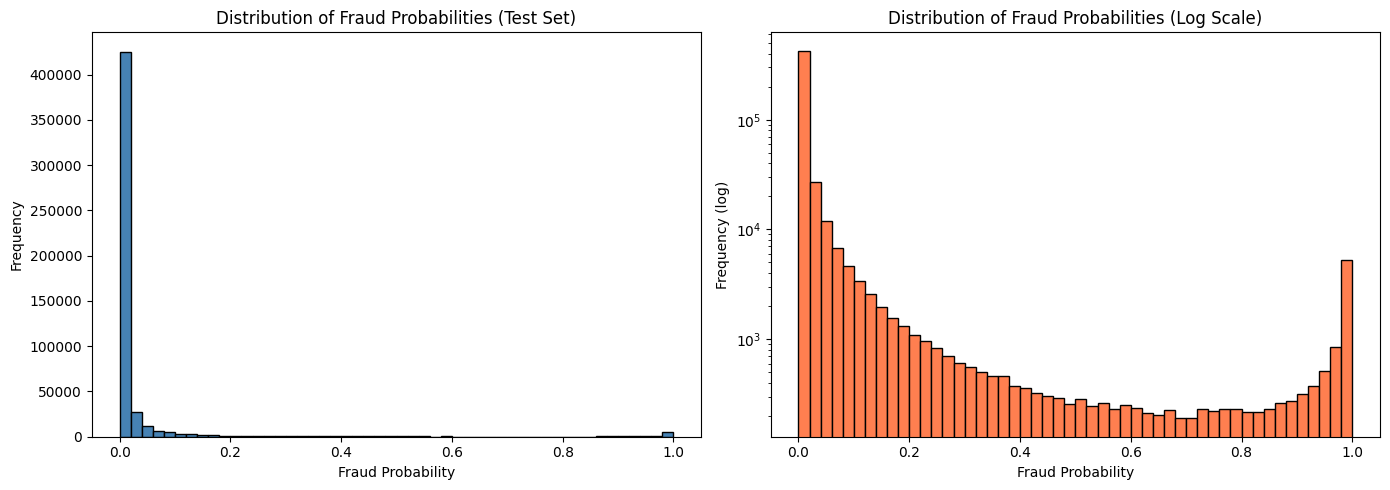

Submission saved as 'submission.csv'


In [23]:
# Create submission
submission = pd.DataFrame({
    'TransactionID': test_id,
    'isFraud': test_predictions
})

print("Submission Preview:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")
print(f"\nPrediction statistics:")
print(submission['isFraud'].describe())

# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(test_predictions, bins=50, color='steelblue', edgecolor='black')
axes[0].set_title('Distribution of Fraud Probabilities (Test Set)')
axes[0].set_xlabel('Fraud Probability')
axes[0].set_ylabel('Frequency')

axes[1].hist(test_predictions, bins=50, color='coral', edgecolor='black', log=True)
axes[1].set_title('Distribution of Fraud Probabilities (Log Scale)')
axes[1].set_xlabel('Fraud Probability')
axes[1].set_ylabel('Frequency (log)')

plt.tight_layout()
plt.show()

# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission saved as 'submission.csv'")

## 24. Model Summary
A final report summarizing the workflow, the model's performance (AUC, Threshold), and listing the most impactful features.
This serves as a quick reference for future iterations.

In [24]:
print("="*70)
print("ENHANCED FRAUD DETECTION MODEL SUMMARY")
print("="*70)

print(f"\n📊 Dataset Information:")
print(f"   - Training samples: {len(X_train):,}")
print(f"   - Test samples: {len(X_test):,}")
print(f"   - Total features: {X_train.shape[1]}")
print(f"   - Fraud rate: {y_train.mean()*100:.2f}%")

print(f"\n🎯 Model Performance:")
print(f"   - Cross-Validation AUC: {np.mean(cv_scores):.6f} (+/- {np.std(cv_scores):.6f})")
print(f"   - Out-of-Fold AUC: {oof_auc:.6f}")
print(f"   - Optimal Threshold: {optimal_threshold:.4f}")

print(f"\n🔧 Feature Engineering Summary:")
print(f"   - Transaction amount features (log, decimal, bins, cents)")
print(f"   - Time features (hour, day, weekend, night, business hours)")
print(f"   - Card combination features")
print(f"   - Email domain features")
print(f"   - Device and browser features")
print(f"   - Address features")
print(f"   - V-column aggregations")
print(f"   - C and D column features")
print(f"   - M column features")
print(f"   - Frequency encoding features")
print(f"   - Aggregation features (mean, std by groups)")

print(f"\n🏆 Top 15 Important Features:")
for i, row in feature_importance.head(15).iterrows():
    print(f"   {i+1:2d}. {row['feature']}: {row['importance']:.2f}")

print("\n" + "="*70)

ENHANCED FRAUD DETECTION MODEL SUMMARY

📊 Dataset Information:
   - Training samples: 590,540
   - Test samples: 506,691
   - Total features: 667
   - Fraud rate: 3.50%

🎯 Model Performance:
   - Cross-Validation AUC: 0.975370 (+/- 0.001674)
   - Out-of-Fold AUC: 0.975206
   - Optimal Threshold: 0.5245

🔧 Feature Engineering Summary:
   - Transaction amount features (log, decimal, bins, cents)
   - Time features (hour, day, weekend, night, business hours)
   - Card combination features
   - Email domain features
   - Device and browser features
   - Address features
   - V-column aggregations
   - C and D column features
   - M column features
   - Frequency encoding features
   - Aggregation features (mean, std by groups)

🏆 Top 15 Important Features:
    1. V258: 959347.17
    2. V91: 494192.79
    3. C13: 468056.79
    4. V70: 408130.36
    5. card1_freq: 380801.26
    6. card1_TransactionAmt_mean: 301531.21
    7. Transaction_week: 293212.60
    8. V294: 282586.31
    9. card1: 278

## 25. Next Steps for Further Improvement

### Additional Feature Engineering:
1. **Target encoding** with cross-validation
2. **Lag features** based on transaction time
3. **User behavior features** (transaction patterns)
4. **Velocity features** (transactions per time window)

### Model Improvements:
1. **Hyperparameter tuning** with Optuna
2. **Ensemble models** (XGBoost, CatBoost, Neural Networks)
3. **Stacking** with different model architectures

### Handling Imbalance:
1. **Focal loss** for neural networks
2. **Cost-sensitive learning**
3. **Threshold optimization** based on business metrics

### Validation Strategy:
1. **Time-based split** for more realistic evaluation
2. **Adversarial validation** to detect distribution shift